In [1]:
import time
import pickle
import importlib.util

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.operators import FermionicOp

description = {'old': 'current version',
               'nnc': 'new no caching',
               'nwc': 'new with caching',}

if importlib.util.find_spec("qiskit_nature.second_q.mappers.mode_based_mapper") is None:
    run = 'old'
elif callable(getattr(JordanWignerMapper, "_pauli_table", None)):
    run = 'nwc'
else:
    run = 'nnc'

print(f"Running version {run}: {description[run]}")

def number_op_timings(mapper, size):
    timings = {}
    for num in range(100, 1001, 100):
        print(f"Mapping {num} operators of length {size}", flush=True)
        op = FermionicOp({" ".join([f"+_{i} -_{i}" for i in range(size)]): 1})
        start = time.time()
        for i in range(num):
            q_ops = mapper.map(op)
        stop = time.time()
        timings[num] = stop - start
    return timings

def parity_op_timings(mapper):
    timings = {}
    for size in range(1, 13):
        print(f"Mapping parity operator of length {size}", flush=True)
        op = FermionicOp.one()
        for i in range(size):
            op @= FermionicOp.one() - 2 * FermionicOp({f"+_{i} -_{i}": 1})
        start = time.time()
        mapper.map(op)
        stop = time.time()
        timings[size] = stop - start
    return timings

def save_timings(mapper_timings, file_name):
    file_name = f"{run}_{file_name.replace(' ','_')}.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(mapper_timings, f)

mappers = {
    'JW': JordanWignerMapper(),
    'Parity': ParityMapper(),
    'BK': BravyiKitaevMapper()
}

print("Timing number operators:")
for size in (5, 10, 15):
    mapper_timings = {}
    for mapper in mappers:
        mapper_timings[mapper] = number_op_timings(mappers[mapper], size)
    save_timings(mapper_timings, f"Number operators of length {size}")

print("Timing parity operators:")
mapper_timings = {}
for mapper in mappers:
    mapper_timings[mapper] = parity_op_timings(mappers[mapper])
save_timings(mapper_timings, "Parity operator")

Running version old: current version
Timing number operators:
Mapping 100 operators of length 5
Mapping 200 operators of length 5
Mapping 300 operators of length 5
Mapping 400 operators of length 5
Mapping 500 operators of length 5
Mapping 600 operators of length 5
Mapping 700 operators of length 5
Mapping 800 operators of length 5
Mapping 900 operators of length 5
Mapping 1000 operators of length 5
Mapping 100 operators of length 5
Mapping 200 operators of length 5
Mapping 300 operators of length 5
Mapping 400 operators of length 5
Mapping 500 operators of length 5
Mapping 600 operators of length 5
Mapping 700 operators of length 5
Mapping 800 operators of length 5
Mapping 900 operators of length 5
Mapping 1000 operators of length 5
Mapping 100 operators of length 5
Mapping 200 operators of length 5
Mapping 300 operators of length 5
Mapping 400 operators of length 5
Mapping 500 operators of length 5
Mapping 600 operators of length 5
Mapping 700 operators of length 5
Mapping 800 operat

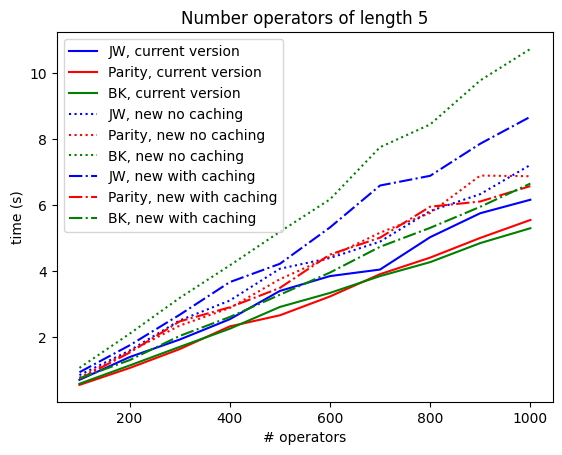

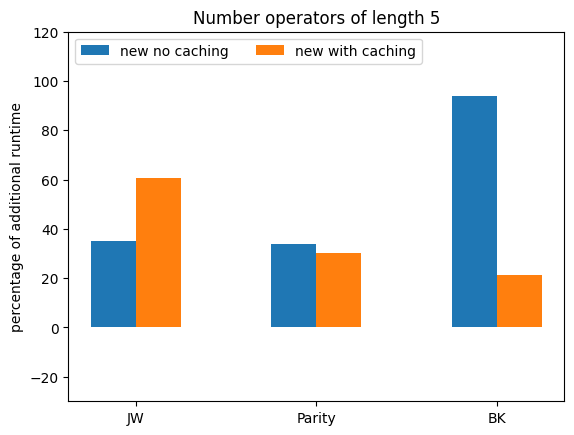

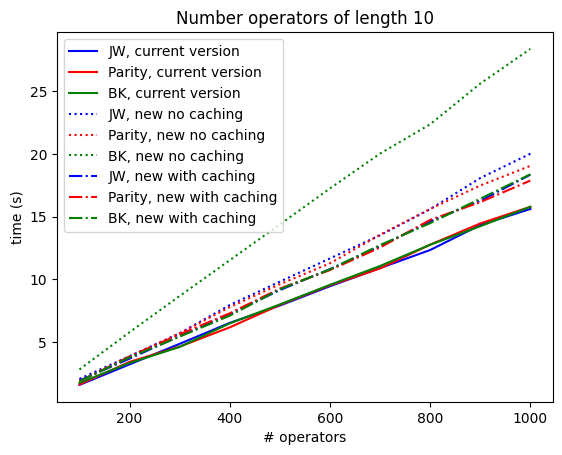

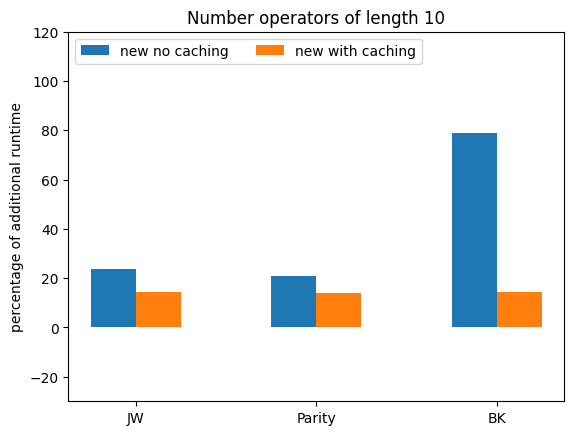

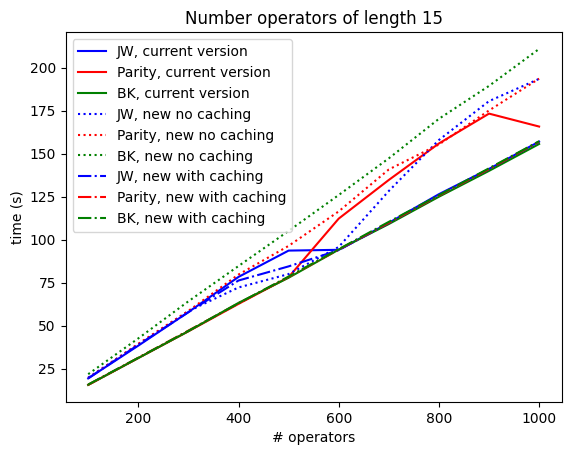

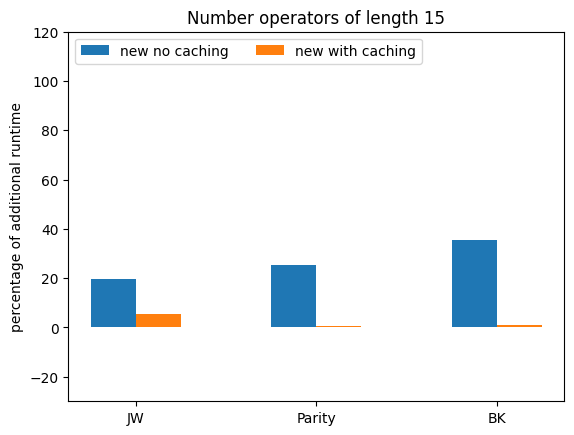

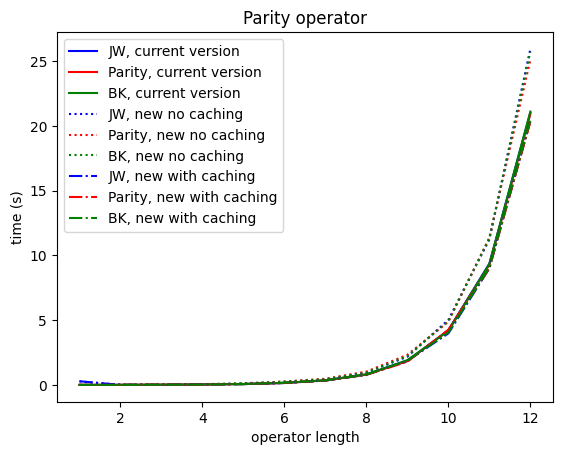

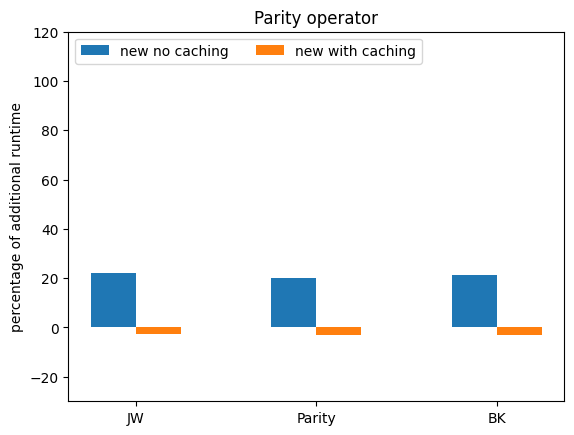

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_timings(mapper_timings, plot_title = '', x_label = ''):
    runs = list(description.keys())
    styles = ['-', ':', '-.']
    colors = ['b', 'r', 'g']

    # Absolute timings
    fig = plt.figure()
    ax = fig.add_subplot()
    for i in range(len(runs)):
        for (mapper, timings), color in zip(mapper_timings[i].items(), colors):
            label = mapper + ', ' + description[runs[i]]
            ax.plot(timings.keys(), timings.values(), color + styles[i], label=label)
    ax.set_xlabel(x_label)
    ax.set_ylabel('time (s)')
    ax.set_title(plot_title)
    ax.legend()
    fig.savefig(f"{plot_title.replace(' ','_')}.png")

    # Relative timings
    fig = plt.figure()
    ax = fig.add_subplot()
    run_names = list(description.values())
    mappers = list(mapper_timings[0].keys())
    ref_timings = np.array(list(mapper_timings[0][mapper].values()))
    timings = {}
    for i in (1, 2):
        rel_timings = [ np.array(list(mapper_timings[i][mapper].values()))
                        / ref_timings for mapper in mappers]
        timings[run_names[i]] = [100*(np.average(r, weights=ref_timings)-1) for r in rel_timings]
    x = np.arange(3)
    width = 0.25
    multiplier = 0
    for run, timing in timings.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, timing, width, label=run)
        multiplier += 1
    ax.set_ylabel('percentage of additional runtime')
    ax.set_title(plot_title)
    ax.set_xticks(x + width/2, mappers)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(-30, 120)
    fig.savefig(f"rel_{plot_title.replace(' ','_')}.png")


for size in (5, 10, 15):
    file_name = f"Number operators of length {size}"
    x_label = "# operators"
    mapper_timings = []
    for run in description:
        with open(f"{run}_{file_name.replace(' ','_')}.pkl", 'rb') as f:
            mapper_timings.append(pickle.load(f))
    plot_timings(mapper_timings, file_name, x_label)

file_name = "Parity operator"
x_label = "operator length"
mapper_timings = []
for run in description:
    with open(f"{run}_{file_name.replace(' ','_')}.pkl", 'rb') as f:
        mapper_timings.append(pickle.load(f))
plot_timings(mapper_timings, file_name, x_label)


In [2]:
import time
import pickle
import scipy
import importlib.util
from collections import defaultdict

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
from qiskit_nature.second_q.hamiltonians.lattices import LineLattice, BoundaryCondition

description = {'old': 'current version',
               'nnc': 'new no caching',
               'nwc': 'new with caching',}

if importlib.util.find_spec("qiskit_nature.second_q.mappers.mode_based_mapper") is None:
    run = 'old'
elif callable(getattr(JordanWignerMapper, "_pauli_table", None)):
    run = 'nwc'
else:
    run = 'nnc'

print(f"Running version {run}: {description[run]}")

def random_rotation(op: FermionicOp) -> FermionicOp:
    """Rotate the modes by a random unitary."""
    u = scipy.stats.unitary_group.rvs(op.num_spin_orbitals)
    terms = defaultdict(float)
    for term, coeff in op.terms():
        new_terms = [('',coeff)]
        for sign, index in term:
            new_new_terms = []
            for i, u_elem in enumerate(u[:,index]):
                new_label = f"{sign}_{i}"
                for label, new_coeff in new_terms:
                    new_new_label = label + ' ' + new_label if label else new_label
                    new_new_terms.append((new_new_label, new_coeff * u_elem))
            new_terms = new_new_terms
        for label, new_coeff in new_terms:
            terms[label] += new_coeff
    return FermionicOp(terms)

def random_hamiltonian(size):
    """Generate a Hamiltonian by randomly rotating the Fermi-Hubbard Hamiltonian."""
    line_lattice = LineLattice(num_nodes=size, boundary_condition=BoundaryCondition.OPEN)
    fermi_hubbard_model = FermiHubbardModel(
        line_lattice.uniform_parameters(
            uniform_interaction=-3.7,
            uniform_onsite_potential=1.3,
        ),
        onsite_interaction=5.2,
    )
    return random_rotation(fermi_hubbard_model.second_q_op())

def ham_op_timings(mapper):
    """Time n Hamiltonians of size n (for n = 1..10)."""
    timings = {}
    for size in range(1, 10):
        print(f"Mapping Hamiltonian of size {size}", flush=True)
        ops = []
        for _ in range(size):
            ops.append(random_hamiltonian(size))
        start = time.time()
        [mapper.map(op) for op in ops]
        stop = time.time()
        timings[size] = stop - start
    return timings

def save_timings(mapper_timings, file_name):
    file_name = f"{run}_{file_name.replace(' ','_')}.pkl"
    with open(file_name, 'wb') as f:
        pickle.dump(mapper_timings, f)

mappers = {
    'JW': JordanWignerMapper(),
    'Parity': ParityMapper(),
    'BK': BravyiKitaevMapper()
}

print("Timing rotated Fermi-Hubbard Hamiltonians:")
mapper_timings = {}
for mapper in mappers:
    mapper_timings[mapper] = ham_op_timings(mappers[mapper])
save_timings(mapper_timings, "Fermi-Hubbard Hamiltonian")

Running version old: current version
Timing rotated Fermi-Hubbard Hamiltonians:
Mapping Hamiltonian of size 1
Mapping Hamiltonian of size 2


Mapping Hamiltonian of size 3
Mapping Hamiltonian of size 4
Mapping Hamiltonian of size 5
Mapping Hamiltonian of size 6
Mapping Hamiltonian of size 7
Mapping Hamiltonian of size 8
Mapping Hamiltonian of size 9
Mapping Hamiltonian of size 1
Mapping Hamiltonian of size 2
Mapping Hamiltonian of size 3
Mapping Hamiltonian of size 4
Mapping Hamiltonian of size 5
Mapping Hamiltonian of size 6
Mapping Hamiltonian of size 7
Mapping Hamiltonian of size 8
Mapping Hamiltonian of size 9
Mapping Hamiltonian of size 1
Mapping Hamiltonian of size 2
Mapping Hamiltonian of size 3
Mapping Hamiltonian of size 4
Mapping Hamiltonian of size 5
Mapping Hamiltonian of size 6
Mapping Hamiltonian of size 7
Mapping Hamiltonian of size 8
Mapping Hamiltonian of size 9


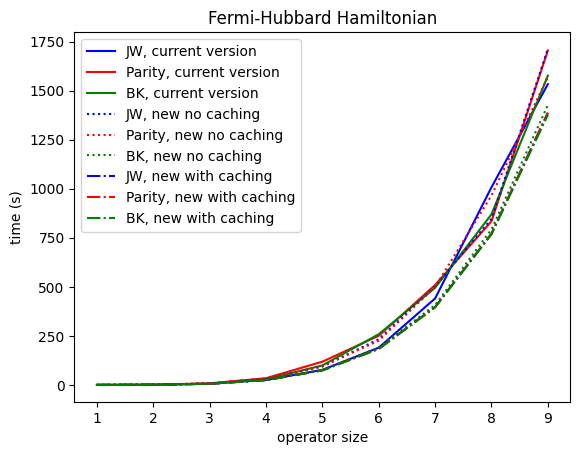

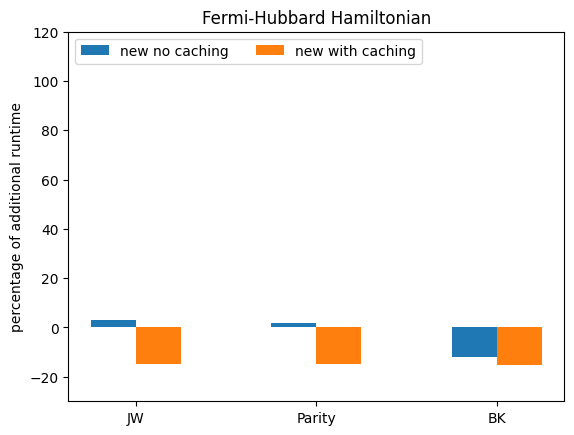

In [4]:
file_name = "Fermi-Hubbard Hamiltonian"
x_label = "operator size"
mapper_timings = []
for run in description:
    with open(f"{run}_{file_name.replace(' ','_')}.pkl", 'rb') as f:
        mapper_timings.append(pickle.load(f))
plot_timings(mapper_timings, file_name, x_label)
